## Clustering of the Neighborhoods in Houston City, Texas

### Section 1: Data collection and data loading into notebook

#### a) Population data of Houston city, TX (1850 - 2010)

In [1]:
import pandas as pd
df_ph = pd.read_csv('population_houston_city.csv')
df_ph.head()

,year,population
0,1850,2396
1,1860,4845
2,1870,9382
3,1880,16513
4,1890,27557


#### b) List of Houston neighborhoods with lattitude and longitude

In [2]:
df_n = pd.read_csv('Houston_Neighborhoods.csv')
df_n.head()

,HoustonNeighborhoods,Index,Latitude,Longitude
0,9_Addicks_Park_Ten,9,29.813300,-95.645500
1,23_AftonOaks_RiverOaks,23,29.749994,-95.433234
2,25_Alief,25,29.682700,-95.593200
3,34_Astrodome_Area,34,29.685045,-95.409813
4,30_Braeburn,30,29.682779,-95.534980


#### c) Loading of 73 uploaded PDF files into notebook

##### c.1 convert PDF into text using PDFMINER.six

In [3]:
 #!conda install -c conda-forge pdfminer --yes
!conda install -c conda-forge pdfminer.six --yes

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - pdfminer.six


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    pdfminer.six-20200517      |             py_1         4.9 MB  conda-forge
    pycryptodome-3.8.2         |   py36hb69a4c5_0         6.9 MB
    sortedcontainers-2.2.2     |     pyh9f0ad1d_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        12.0 MB

The following NEW packages will be INSTALLED:

  chardet            conda-forge/linux-64::chardet-3.0.4-py36h9f0ad1d_1006
  pdfminer.six       conda-forge/noarch::pdfminer.six-20200517-py_1
  pycryptodome       pkgs/main/linux-64::pycryptodome-3.8.2-py36hb69a4c5_0
  sorted

In [4]:
import io

from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage


def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = io.StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos = set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages,
                                  password=password,
                                  caching=caching,
                                  check_extractable=True):
        interpreter.process_page(page)



    fp.close()
    device.close()
    text = retstr.getvalue()
    retstr.close()
    return text

In [5]:
import numpy as np
neighbor = df_n.loc[:,'HoustonNeighborhoods'].to_numpy()
filename = []
for i in range(len(neighbor)):
    fname = str(neighbor[i]) + '_v2.pdf'
    filename.append(fname)

### Section 2: Data preparation and generation of dataframe

#### a) parse feature data from text

In [6]:
#function of searching for the various information from the text 

def parse_value(tt):
    begin = tt.find('characteristics')
    text = tt[begin:]
    list1 = []
#find the Median Household Income for 2015
    i1 = text.find('Median Household Income')
    tt_i1 = text[i1:]
    i2 = tt_i1.find('$')
    tt_i2 = tt_i1[i2+1:]
    i3 = tt_i2.find('$')
    tt_i3 = tt_i2[i3:]
    i4a = tt_i3.find('$')
    i4b = tt_i3.find(',')
    i4c = tt_i3.find(' ')
    if i4b<i4c:
        tt_i4 = tt_i3[i4a+1:i4b] + tt_i3[i4b+1:i4c]
    else:
        tt_i4 = tt_i3[i4a+1:i4c]
    if tt_i4 == ' ':
        Income_Median = float('NaN')
    else:
        Income_Median = float(tt_i4)
    list1.append(Income_Median)
    #print('Income_Median = ', Income_Median)

#find the Median Housing Value
    j1 = text.find('Median Housing Value')
    tt_j1 = text[j1:]
    j2 = tt_j1.find('$')
    tt_j2 = tt_j1[j2+1:]
    j3 = tt_j2.find('$')
    tt_j3 = tt_j2[j3:]
    j4a = tt_j3.find('$')
    j4b = tt_j3.find(',')
    j4c = tt_j3.find(' ')
    if j4b<j4c:
        tt_j4 = tt_j3[j4a+1:j4b] + tt_j3[j4b+1:j4c]
    else:
        tt_j4 = tt_j3[j4a+1:j4c]
    if tt_j4 == '':
        Housing_Median = float('NaN')
    else:
        Housing_Median = float(tt_j4)
    list1.append(Housing_Median)
    #print('Housing_Median = ', Housing_Median)

#find the total population and persons per sq. mile
    k1 = text.find('population')
    tt_k1 = text[k1:]
    k2 = tt_k1.find(' ')
    tt_k2 = tt_k1[k2+1:]
    k3 = tt_k2.find(' ')
    tt_k3 = tt_k2[k3+1:]
    k3b = tt_k3.find(' ')
    tt_k3b = tt_k3[0:k3b]
    k3c = tt_k3b.find(',')
    if k3c == -1:
        tt_k3b = tt_k3[0:k3b]
    else:
        tt_k3b = tt_k3[0:k3c] + tt_k3[k3c+1:k3b]
    if tt_k3b == '':
        Population_Total = float('NaN')
    else:
        Population_Total = float(tt_k3b)
        
    k4 = tt_k2.find('sq. mile')
    tt_k4 = tt_k2[k4+5:]
    k5 = tt_k4.find(' ')
    tt_k5 = tt_k4[k5+1:]
    k6a = tt_k5.find(' ')
    tt_k6 = tt_k5[k6a+1:]
    k6b = tt_k6.find(' ')
    tt_k6b = tt_k6[0:k6b]
    k6c = tt_k6b.find(',')
    if k6c == -1:
        tt_k6b = tt_k6[0:k6b]
    else:
        tt_k6b = tt_k6[0:k6c] + tt_k6[k6c+1:k6b]
    Psmile_Person = float(tt_k6b)
    list1.append(Population_Total)
    list1.append(Psmile_Person)
    #print('Population_Total = ', Population_Total)
    #print('Psmile_Person = ', Psmile_Person)

#find all the percentage values into a list
    l1 = text.find('%')
    l1end = text.find('Median Housing Value')
    tt_l1 = text[l1-2:l1end]  
    for i in range(len(tt_l1)):
        if tt_l1[i] == '%':
            list1.append(float(tt_l1[i-2:i]))
    list2 = list1[0:4]
    for kk in range(17):
        index = 4*kk+5
        list2.append(list1[index])
    
    #print(list1)
    return list2

In [7]:
neighbor = df_n.loc[:,'HoustonNeighborhoods'].to_numpy()
data = {}
for i in range(len(filename)):
    #print('the current file is: ',filename[i])
    tt = convert_pdf_to_txt(filename[i])
    data[neighbor[i]] = parse_value(tt)

#### b) generate and combine datafame

In [8]:
df_data = pd.DataFrame.from_dict(data, orient='index',
                                 columns=['Income_Median', 'Housing_Median', 'Population_Total',
                                          'Psmile_Person', 'Age%_Under5', 'Age%_5_17','Age%_18_64',
                                          'Age%_65up', 'Non_Hispanic%_W', 'Non_Hispanic%_B',
                                          'Hispanic%', 'Non_Hispanic%_A', 'Nin_Hispanic%_O',
                                          'Income%_U25k', 'Income%_U50k', 'Income%_U100k',
                                          'Income%_100kup', 'No_Diploma%', 'High_School%',
                                          'College%', 'Bachelor_Or_Higher%']
                                )

df_data['Index'] = df_n['Index'].to_numpy()
dft = pd.merge(df_n, df_data, on='Index')
dft.head()

,HoustonNeighborhoods,Index,Latitude,Longitude,Income_Median,Housing_Median,Population_Total,Psmile_Person,Age%_Under5,Age%_5_17,...,Non_Hispanic%_A,Nin_Hispanic%_O,Income%_U25k,Income%_U50k,Income%_U100k,Income%_100kup,No_Diploma%,High_School%,College%,Bachelor_Or_Higher%
0,9_Addicks_Park_Ten,9,29.813300,-95.645500,80584.0,168155.0,19683.0,840.0,5.0,17.0,...,12.0,1.0,11.0,24.0,33.0,32.0,9.0,19.0,27.0,39.0
1,23_AftonOaks_RiverOaks,23,29.749994,-95.433234,95682.0,499169.0,14518.0,4021.0,5.0,14.0,...,7.0,2.0,9.0,10.0,23.0,58.0,3.0,4.0,19.0,74.0
2,25_Alief,25,29.682700,-95.593200,41833.0,90655.0,106657.0,7544.0,7.0,20.0,...,19.0,1.0,32.0,33.0,25.0,9.0,35.0,26.0,24.0,15.0
3,34_Astrodome_Area,34,29.685045,-95.409813,46284.0,102268.0,18223.0,4846.0,5.0,6.0,...,31.0,3.0,26.0,26.0,32.0,15.0,2.0,7.0,20.0,72.0
4,30_Braeburn,30,29.682779,-95.534980,42958.0,116547.0,18843.0,4711.0,8.0,18.0,...,5.0,0.0,41.0,26.0,22.0,11.0,28.0,30.0,22.0,20.0


### Section 3: Data Analysis

#### a) Prediction of 2019 population from df_ph (1850 - 2010)

In [9]:
df_temp = pd.DataFrame({'year': 2019, 'population':2320268}, index=range(1))
df_temp.head()

,year,population
0,2019,2320268


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

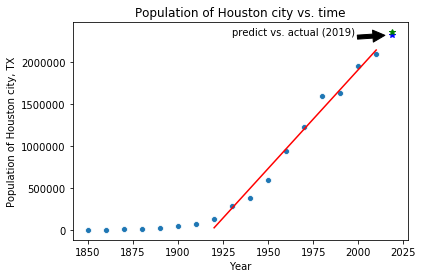

In [11]:
x = df_ph.iloc[7:,][['year']]
y = df_ph.iloc[7:,]['population']

polynomial_features= PolynomialFeatures(degree=1)
x1 = polynomial_features.fit_transform(x)

model1 = LinearRegression()
model1.fit(x1,y)
y_hat = model1.predict(x1)

df_ph_test = pd.DataFrame({'year': 2019, 'population': 2320268}, index = range(1))
xtest = df_ph_test[['year']]
ytest = df_ph_test['population']
xtest1 = polynomial_features.fit_transform(xtest)
y_hat_test = model1.predict(xtest1)
x1 = polynomial_features.fit_transform(x)

ax = sns.scatterplot(x='year',y='population',data = df_ph)
ax.set(xlabel = 'Year', ylabel = 'Population of Houston city, TX', title ='Population of Houston city vs. time')
ax.annotate('predict vs. actual (2019)', xy=(2015, 2320000), xytext=(1930, 2320000),
            arrowprops=dict(facecolor='black', shrink=0.01),
            )

plt.plot(x,y_hat,'r')
plt.plot(xtest,ytest,'b*')
plt.plot(xtest,y_hat_test,'g*')

plt.show()

### b) Explore Houston Neighborhoods and clustering by the venues

In [12]:
address = 'Houston, Texas'
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="h_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Houston are {}, {}.'.format(latitude, longitude))

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

In [13]:
# create map of Houston using latitude and longitude values
import folium
map_h = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(dft['Latitude'], dft['Longitude'], dft['HoustonNeighborhoods']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_h)  
    
map_h

#### b.1) preparation to use FourSquare to explore the Venues around the neighborhoods

In [14]:
CLIENT_ID = 'O22FUJMMFHZYPFQ3IVCCEK5XFFTDSZGR0YDRSXHD4X01ZOPL' # your Foursquare ID
CLIENT_SECRET = 'TTUS3HGOT0BGINEUAIA2LUY3LQ0ZTCWCFBL14GENOA1N1SME' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: O22FUJMMFHZYPFQ3IVCCEK5XFFTDSZGR0YDRSXHD4X01ZOPL
CLIENT_SECRET:TTUS3HGOT0BGINEUAIA2LUY3LQ0ZTCWCFBL14GENOA1N1SME


In [15]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### b.2) nearby venues

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']      
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
dfth = dft.iloc[0:73,:]
dfth.head()

,HoustonNeighborhoods,Index,Latitude,Longitude,Income_Median,Housing_Median,Population_Total,Psmile_Person,Age%_Under5,Age%_5_17,Age%_18_64,Age%_65up,Non_Hispanic%_W,Non_Hispanic%_B,Hispanic%,Non_Hispanic%_A,Nin_Hispanic%_O,Income%_U25k,Income%_U50k,Income%_U100k,Income%_100kup,No_Diploma%,High_School%,College%,Bachelor_Or_Higher%
0,9_Addicks_Park_Ten,9,29.813300,-95.645500,80584.0,168155.0,19683.0,840.0,5.0,17.0,71.0,7.0,41.0,15.0,32.0,12.0,1.0,11.0,24.0,33.0,32.0,9.0,19.0,27.0,39.0
1,23_AftonOaks_RiverOaks,23,29.749994,-95.433234,95682.0,499169.0,14518.0,4021.0,5.0,14.0,61.0,20.0,77.0,4.0,10.0,7.0,2.0,9.0,10.0,23.0,58.0,3.0,4.0,19.0,74.0
2,25_Alief,25,29.682700,-95.593200,41833.0,90655.0,106657.0,7544.0,7.0,20.0,65.0,8.0,9.0,22.0,49.0,19.0,1.0,32.0,33.0,25.0,9.0,35.0,26.0,24.0,15.0
3,34_Astrodome_Area,34,29.685045,-95.409813,46284.0,102268.0,18223.0,4846.0,5.0,6.0,84.0,5.0,34.0,22.0,10.0,31.0,3.0,26.0,26.0,32.0,15.0,2.0,7.0,20.0,72.0
4,30_Braeburn,30,29.682779,-95.534980,42958.0,116547.0,18843.0,4711.0,8.0,18.0,63.0,10.0,24.0,16.0,55.0,5.0,0.0,41.0,26.0,22.0,11.0,28.0,30.0,22.0,20.0


In [19]:
H0_venues = getNearbyVenues(names=dfth['HoustonNeighborhoods'],
                                   latitudes=dfth['Latitude'],
                                   longitudes=dfth['Longitude']
                                  )


9_Addicks_Park_Ten
23_AftonOaks_RiverOaks
25_Alief
34_Astrodome_Area
30_Braeburn
32_Braeswood_Place
36_GreaterFondren_Southwest
18_Briarforest
3_Carverdale
40_Central_Southwest
81_Clear_Lake
59_ClintonPark_TriCommunity
56_DenverHarbor_PortHouston
61_Downtown
49_East_Houston
47_EastLittleYork_Homestead
46_Eastex_Jensen
79_Edgebrook
53_Eldorado_OatesPrairie
4_Fairbanks_NorthwestCrossing
39_Fondren_Gardens
41_FortBend_Houston
60_Fourth_Ward
73_GolfcrestBellfort_Reveille
64_Greater_Eastwood
55_Greater_FifthWard
2_Greater_Greenspoint
78_Greater_HobbyArea
68_OST_SouthUnion
67_Greater_ThirdWard
21_Greater_Uptown
87_Greenway_UpperKirby
69_GulfgateRiverview_PineValley
27_Gulfton
65_Harrisburg_Manchester
7_Hidden_Valley
54_Hunterwood
13_Independence_Heights
52_Kashmere_Gardens
11_Langwood
88_Lawndale_Wayside
83_Macgregor
82_Magnolia_Park
75_Meadowbrook_Allendale
33_Medical_Center
31_Meyerland
62_Midtown
77_Minnetex
66_MuseumPark
51_Northside_Village
38_WillowMeadows_WillowBend
58_Northshore
45_N

In [20]:
#H0_venues.to_csv('H0_venues.csv')
#H1_venues.to_csv('H1_venues.csv')
H_venues = pd.read_csv('H_venues.csv')
H_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,9_Addicks_Park_Ten,29.8133,-95.6455,Bill Archer Dog Park,29.817540,-95.647513,Dog Run
1,9_Addicks_Park_Ten,29.8133,-95.6455,Frank's Grill,29.835400,-95.645349,Diner
2,9_Addicks_Park_Ten,29.8133,-95.6455,Bear Creek Park,29.830810,-95.630370,Park
3,9_Addicks_Park_Ten,29.8133,-95.6455,Los Cucos Mexican Cafe,29.836669,-95.648518,Mexican Restaurant
4,9_Addicks_Park_Ten,29.8133,-95.6455,Topgolf,29.786776,-95.650101,Golf Driving Range


In [21]:
H_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
11_Langwood,100,100,100,100,100,100
13_Independence_Heights,100,100,100,100,100,100
18_Briarforest,100,100,100,100,100,100
19_Westchase,100,100,100,100,100,100
1_Willowbrook,100,100,100,100,100,100
21_Greater_Uptown,100,100,100,100,100,100
23_AftonOaks_RiverOaks,100,100,100,100,100,100
25_Alief,100,100,100,100,100,100
26_Sharpstown,100,100,100,100,100,100


In [22]:
H_venues.shape

(6969, 7)

In [23]:
print('There are {} uniques categories.'.format(len(H_venues['Venue Category'].unique())))

There are 267 uniques categories.


In [24]:
# one hot encoding
H_onehot = pd.get_dummies(H_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
H_onehot['Neighborhood'] = H_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [H_onehot.columns[-1]] + list(H_onehot.columns[:-1])
H_onehot = H_onehot[fixed_columns]

H_onehot.head()

,Neighborhood,Accessories Store,Advertising Agency,African Restaurant,Airport,Airport Food Court,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hunan Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Internet Cafe,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Street Art,Student Center,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,9_Addicks_Park_Ten,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [25]:
H_onehot.shape

(6969, 268)

In [26]:
H_grouped = H_onehot.groupby('Neighborhood').mean().reset_index()
H_grouped

,Neighborhood,Accessories Store,Advertising Agency,African Restaurant,Airport,Airport Food Court,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hunan Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Internet Cafe,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Street Art,Student Center,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,11_Langwood,0.00,0.01,0.00,0.000000,0.000000,0.000000,0.00000,0.00

In [27]:
H_grouped.shape

(73, 268)

#### b.3) get the top 5 venues

In [28]:
num_top_venues = 5

for hood in H_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = H_grouped[H_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----11_Langwood----
                venue  freq
0  Mexican Restaurant  0.10
1      Sandwich Place  0.05
2        Burger Joint  0.05
3         Coffee Shop  0.05
4          Donut Shop  0.04


----13_Independence_Heights----
                venue  freq
0  Mexican Restaurant  0.09
1         Coffee Shop  0.05
2        Burger Joint  0.04
3         Beer Garden  0.04
4         Pizza Place  0.04


----18_Briarforest----
                   venue  freq
0          Grocery Store  0.06
1     Mexican Restaurant  0.04
2  Vietnamese Restaurant  0.03
3         Sandwich Place  0.03
4      French Restaurant  0.03


----19_Westchase----
                   venue  freq
0          Grocery Store  0.05
1                 Bakery  0.04
2       Asian Restaurant  0.04
3     Chinese Restaurant  0.04
4  Vietnamese Restaurant  0.03


----1_Willowbrook----
                    venue  freq
0      Mexican Restaurant  0.08
1     American Restaurant  0.06
2      Seafood Restaurant  0.04
3  Furniture / Home Store  0.04
4     

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
H_venues_sorted = pd.DataFrame(columns=columns)
H_venues_sorted['Neighborhood'] = H_grouped['Neighborhood']

for ind in np.arange(H_grouped.shape[0]):
    H_venues_sorted.iloc[ind, 1:] = return_most_common_venues(H_grouped.iloc[ind, :], num_top_venues)

H_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,11_Langwood,Mexican Restaurant,Burger Joint,Sandwich Place,Coffee Shop,Donut Shop,Gym,Deli / Bodega,Seafood Restaurant,Sports Bar,Vietnamese Restaurant
1,13_Independence_Heights,Mexican Restaurant,Coffee Shop,Burger Joint,Beer Garden,Pizza Place,Gym,Wine Bar,BBQ Joint,Bakery,Taco Place
2,18_Briarforest,Grocery Store,Mexican Restaurant,Park,Gym / Fitness Center,Hawaiian Restaurant,Breakfast Spot,French Restaurant,Burger Joint,Vietnamese Restaurant,Sandwich Place
3,19_Westchase,Grocery Store,Asian Restaurant,Chinese Restaurant,Bakery,Mexican Restaurant,Sushi Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Coffee Shop,Sandwich Place
4,1_Willowbrook,Mexican Restaurant,American Restaurant,Furniture / Home Store,Seafood Restaurant,Gym,Coffee Shop,Italian Restaurant,Golf Course,Smoothie Shop,Sporting Goods Shop


#### b.4) Cluster Neighborhoods by venues

In [31]:
# set number of clusters
kclusters = 5

H_grouped_clustering = H_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(H_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:73] 

array([3, 3, 3, 0, 3, 3, 3, 0, 0, 3, 3, 0, 1, 0, 3, 3, 2, 3, 3, 3, 3, 3,
       1, 3, 1, 4, 1, 3, 4, 4, 4, 3, 4, 2, 1, 1, 4, 2, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 3, 1, 4, 1, 1, 1, 4, 1, 1, 3, 1, 3, 3, 1, 2,
       3, 3, 3, 3, 2, 1, 3], dtype=int32)

In [32]:
H_venues_sorted['HoustonNeighborhoods'] = H_venues_sorted['Neighborhood']
H_venues_sorted.drop(['Neighborhood'], axis=1)
H_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,HoustonNeighborhoods
0,11_Langwood,Mexican Restaurant,Burger Joint,Sandwich Place,Coffee Shop,Donut Shop,Gym,Deli / Bodega,Seafood Restaurant,Sports Bar,Vietnamese Restaurant,11_Langwood
1,13_Independence_Heights,Mexican Restaurant,Coffee Shop,Burger Joint,Beer Garden,Pizza Place,Gym,Wine Bar,BBQ Joint,Bakery,Taco Place,13_Independence_Heights
2,18_Briarforest,Grocery Store,Mexican Restaurant,Park,Gym / Fitness Center,Hawaiian Restaurant,Breakfast Spot,French Restaurant,Burger Joint,Vietnamese Restaurant,Sandwich Place,18_Briarforest
3,19_Westchase,Grocery Store,Asian Restaurant,Chinese Restaurant,Bakery,Mexican Restaurant,Sushi Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Coffee Shop,Sandwich Place,19_Westchase
4,1_Willowbrook,Mexican Restaurant,American Restaurant,Furniture / Home Store,Seafood Restaurant,Gym,Coffee Shop,Italian Restaurant,Golf Course,Smoothie Shop,Sporting Goods Shop,1_Willowbrook


In [33]:
H_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

H_merged = dfth
H_merged = H_merged.join(H_venues_sorted.set_index('HoustonNeighborhoods'), on='HoustonNeighborhoods')

H_merged.head()

,HoustonNeighborhoods,Index,Latitude,Longitude,Income_Median,Housing_Median,Population_Total,Psmile_Person,Age%_Under5,Age%_5_17,Age%_18_64,Age%_65up,Non_Hispanic%_W,Non_Hispanic%_B,Hispanic%,Non_Hispanic%_A,Nin_Hispanic%_O,Income%_U25k,Income%_U50k,Income%_U100k,Income%_100kup,No_Diploma%,High_School%,College%,Bachelor_Or_Higher%,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,9_Addicks_Park_Ten,9,29.813300,-95.645500,80584.0,168155.0,19683.0,840.0,5.0,17.0,71.0,7.0,41.0,15.0,32.0,12.0,1.0,11.0,24.0,33.0,32.0,9.0,19.0,27.0,39.0,3,9_Addicks_Park_Ten,Mexican Restaurant,Park,Pizza Place,Coffee Shop,Hotel,Grocery Store,Sandwich Place,Convenience Store,Gas Station,Italian Restaurant
1,23_AftonOaks_RiverOaks,23,29.749994,-95.433234,95682.0,499169.0,14518.0,4021.0,5.0,14.0,61.0,20.0,77.0,4.0,10.0,7.0,2.0,9.0,10.0,23.0,58.0,3.0,4.0,19.0,74.0,3,23_AftonOaks_RiverOaks,Italian Restaurant,Ice Cream Shop,Grocery Store,Sushi Restaurant,Mexican Restaurant,American Restaurant,New American Restaurant,Burger Joint,Café,Seafood Restaurant
2,25_Alief,25,29.682700,-95.593200,41833.0,90655.0,106657.0,7544.0,7.0,20.0,65.0,8.0,9.0,22.0,49.0,19.0,1.0,32.0,33.0,25.0,9.0,35.0,26.0,24.0,15.0,0,25_Alief,Vietnamese Restaurant,Asian Restaurant,Chinese Restaurant,Cajun / Creole Restaurant,Mexican Restaurant,Pharmacy,Fast Food Restaurant,Bakery,Noodle House,Pakistani Restaurant
3,34_Astrodome_Area,34,29.685045,-95.409813,46284.0,102268.0,18223.0,4846.0,5.0,6.0,84.0,5.0,34.0,22.0,10.0,31.0,3.0,26.0,26.0,32.0,15.0,2.0,7.0,20.0,72.0,3,34_Astrodome_Area,Zoo Exhibit,Mexican Restaurant,Sandwich Place,Burger Joint,Bakery,American Restaurant,Ice Cream Shop,Food Truck,Gym,Seafood Restaurant
4,30_Braeburn,30,29.682779,-95.534980,42958.0,116547.0,18843.0,4711.0,8.0,18.0,63.0,10.0,24.0,16.0,55.0,5.0,0.0,41.0,26.0,22.0,11.0,28.0,30.0,22.0,20.0,0,30_Braeburn,Chinese Restaurant,Bakery,Asian Restaurant,Bubble Tea Shop,Korean Restaurant,Vietnamese Restaurant,Cajun / Creole Restaurant,Café,Grocery Store,Fast Food Restaurant


#### b.5) Visualize the resulting clusters (by venues)

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(H_merged['Latitude'], H_merged['Longitude'], H_merged['Neighborhood'], H_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

##### b.5.1) Cluster 1

In [35]:
H_merged.loc[H_merged['Cluster Labels'] == 0, H_merged.columns[[1] + list(range(4, H_merged.shape[1]))]]

,Index,Income_Median,Housing_Median,Population_Total,Psmile_Person,Age%_Under5,Age%_5_17,Age%_18_64,Age%_65up,Non_Hispanic%_W,Non_Hispanic%_B,Hispanic%,Non_Hispanic%_A,Nin_Hispanic%_O,Income%_U25k,Income%_U50k,Income%_U100k,Income%_100kup,No_Diploma%,High_School%,College%,Bachelor_Or_Higher%,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,25,41833.0,90655.0,106657.0,7544.0,7.0,20.0,65.0,8.0,9.0,22.0,49.0,19.0,1.0,32.0,33.0,25.0,9.0,35.0,26.0,24.0,15.0,0,25_Alief,Vietnamese Restaurant,Asian Restaurant,Chinese Restaurant,Cajun / Creole Restaurant,Mexican Restaurant,Pharmacy,Fast Food Restaurant,Bakery,Noodle House,Pakistani Restaurant
4,30,42958.0,116547.0,18843.0,4711.0,8.0,18.0,63.0,10.0,24.0,16.0,55.0,5.0,0.0,41.0,26.0,22.0,11.0,28.0,30.0,22.0,20.0,0,30_Braeburn,Chinese Restaurant,Bakery,Asian Restaurant,Bubble Tea Shop,Korean Restaurant,Vietnamese Restaurant,Cajun / Creole Restaurant,Café,Grocery Store,Fast Food Restaurant
58,26,33086.0,67412.0,77220.0,9045.0,9.0,19.0,63.0,9.0,12.0,13.0,58.0,15.0,2.0,41.0,32.0,19.0,8.0,36.0,25.0,21.0,17.0,0,26_Sharpstown,Chinese Restaurant,Bakery,Asian Restaurant,Vietnamese Restaurant,Bubble Tea Shop,Korean Restaurant,Latin American Restaurant,Cajun / Creole Restaurant,Fast Food Restaurant,Café
70,19,48898.0,138640.0,29149.0,6745.0,8.0,10.0,75.0,7.0,25.0,33.0,26.0,13.0,2.0,29.0,33.0,24.0,15.0,11.0,19.0,30.0,39.0,0,19_Westchase,Grocery Store,Asian Restaurant,Chinese Restaurant,Bakery,Mexican Restaurant,Sushi Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Coffee Shop,Sandwich Place
71,29,29527.0,37690.0,19530.0,8951.0,13.0,24.0,61.0,3.0,2.0,23.0,68.0,5.0,1.0,56.0,29.0,13.0,1.0,43.0,30.0,18.0,10.0,0,29_Westwood,Chinese Restaurant,Asian Restaurant,Bakery,Vietnamese Restaurant,Bubble Tea Shop,Korean Restaurant,Cajun / Creole Restaurant,Mexican Restaurant,Noodle House,Café


##### b.5.2) Cluster 2

In [36]:
H_merged.loc[H_merged['Cluster Labels'] == 1, H_merged.columns[[1] + list(range(4, H_merged.shape[1]))]]

,Index,Income_Median,Housing_Median,Population_Total,Psmile_Person,Age%_Under5,Age%_5_17,Age%_18_64,Age%_65up,Non_Hispanic%_W,Non_Hispanic%_B,Hispanic%,Non_Hispanic%_A,Nin_Hispanic%_O,Income%_U25k,Income%_U50k,Income%_U100k,Income%_100kup,No_Diploma%,High_School%,College%,Bachelor_Or_Higher%,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,40,47057.0,97313.0,66918.0,2817.0,7.0,22.0,62.0,8.0,5.0,45.0,47.0,3.0,0.0,24.0,30.0,35.0,11.0,27.0,29.0,26.0,18.0,1,40_Central_Southwest,Grocery Store,Pharmacy,Fast Food Restaurant,Burger Joint,Sandwich Place,Pizza Place,Discount Store,Fried Chicken Joint,Bank,BBQ Joint
11,59,31826.0,68741.0,3140.0,1144.0,9.0,16.0,63.0,12.0,5.0,48.0,44.0,1.0,2.0,42.0,35.0,18.0,6.0,31.0,35.0,24.0,10.0,1,59_ClintonPark_TriCommunity,Mexican Restaurant,Sandwich Place,Pizza Place,Fast Food Restaurant,Bar,Fried Chicken Joint,Pharmacy,Bakery,Snack Place,Music Venue
12,56,29273.0,69150.0,17571.0,2749.0,8.0,21.0,61.0,11.0,3.0,7.0,89.0,0.0,0.0,41.0,32.0,22.0,6.0,55.0,24.0,17.0,6.0,1,56_DenverHarbor_PortHouston,Mexican Restaurant,Fast Food Restaurant,Fried Chicken Joint,Gas Station,Sandwich Place,Pizza Place,Discount Store,Burger Joint,Snack Place,Bank
18,53,39216.0,84312.0,3852.0,856.0,5.0,15.0,71.0,9.0,17.0,21.0,62.0,0.0,0.0,24.0,28.0,38.0,10.0,35.0,35.0,25.0,4.0,1,53_Eldorado_OatesPrairie,Mexican Restaurant,Fast Food Restaurant,Sandwich Place,Gas Station,Discount Store,Fried Chicken Joint,Pizza Place,Seafood Restaurant,Convenience Store,Pharmacy
20,39,53968.0,108564.0,2730.0,2292.0,8.0,15.0,66.0,10.0,14.0,33.0,52.0,1.0,0.0,22.0,32.0,39.0,7.0,31.0,19.0,35.0,15.0,1,39_Fondren_Gardens,Mexican Restaurant,Pharmacy,Sandwich Place,Burger Joint,Grocery Store,Fast Food Restaurant,Discount Store,Coffee Shop,Gas Station,Bar
23,73,34731.0,78603.0,51432.0,5589.0,9.0,21.0,62.0,9.0,8.0,20.0,68.0,3.0,0.0,37.0,31.0,23.0,10.0,40.0,32.0,19.0,10.0,1,73_GolfcrestBellfort_Reveille,Discount Store,Fast Food Restaurant,Pharmacy,Mexican Restaurant,Mobile Phone Shop,Sandwich Place,Pizza Place,Fried Chicken Joint,Rental Car Location,Seafood Restaurant
26,2,33909.0,55134.0,41392.0,5951.0,14.0,23.0,59.0,4.0,5.0,27.0,67.0,1.0,1.0,48.0,33.0,16.0,3.0,46.0,28.0,20.0,6.0,1,2_Greater_Greenspoint,Discount Store,Fried Chicken Joint,Hotel,Mexican Restaurant,Seafood Restaurant,Pizza Place,Sandwich Place,Fast Food Restaurant,Burger Joint,Grocery Store
27,78,50832.0,106904.0,25385.0,2102.0,10.0,21.0,63.0,6.0,7.0,18.0,72.0,3.0,0.0,30.0,28.0,28.0,14.0,38.0,31.0,21.0,10.0,1,78_Greater_HobbyArea,Discount Store,Rental Car Location,Fast Food Restaurant,Gas Station,Mexican Restaurant,Coffee Shop,Burger Joint,Mobile Phone Shop,Park,Sandwich Place
34,65,37359.0,75196.0,2926.0,1208.0,8.0,19.0,65.0,8.0,3.0,14.0,82.0,0.0,0.0,41.0,20.0,27.0,11.0,44.0,26.0,20.0,10.0,1,65_Harrisburg_Manchester,Mexican Restaurant,Breakfast Spot,Gas Station,Fast Food Restaurant,Pharmacy,Pizza Place,Ice Cream Shop,Sandwich Place,Wings Joint,Seafood Restaurant
35,7,34452.0,87584.0,3569.0,4055.0,5.0,21.0,60.0,14.0,17.0,15.0,65.0,3.0,0.0,26.0,29.0,39.0,6.0,33.0,36.0,20.0,11.0,1,7_Hidden_Valley,Mexican Restaurant,Discount Store,Pharmacy,Seafood Restaurant,Electronics Store,Gas Station,Coffee Shop,Bubble Tea Shop,Breakfast Spot,Mobile Phone Shop


##### b.5.3) Cluster 3

In [37]:
H_merged.loc[H_merged['Cluster Labels'] == 2, H_merged.columns[[1] + list(range(4, H_merged.shape[1]))]]

,Index,Income_Median,Housing_Median,Population_Total,Psmile_Person,Age%_Under5,Age%_5_17,Age%_18_64,Age%_65up,Non_Hispanic%_W,Non_Hispanic%_B,Hispanic%,Non_Hispanic%_A,Nin_Hispanic%_O,Income%_U25k,Income%_U50k,Income%_U100k,Income%_100kup,No_Diploma%,High_School%,College%,Bachelor_Or_Higher%,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,61,71666.0,200831.0,12088.0,4464.0,1.0,3.0,91.0,4.0,33.0,32.0,29.0,5.0,1.0,21.0,13.0,24.0,42.0,25.0,24.0,22.0,29.0,2,61_Downtown,Vietnamese Restaurant,Bar,Mexican Restaurant,Hotel,Brewery,Beer Garden,Park,Wine Bar,Pizza Place,Coffee Shop
22,60,88231.0,334934.0,4085.0,8781.0,4.0,11.0,79.0,6.0,46.0,27.0,18.0,9.0,0.0,32.0,14.0,21.0,34.0,10.0,7.0,23.0,61.0,2,60_Fourth_Ward,Coffee Shop,Pizza Place,Trail,Mediterranean Restaurant,Taco Place,Beer Garden,Breakfast Spot,Park,Gym,American Restaurant
24,64,48426.0,147557.0,10776.0,5747.0,6.0,17.0,67.0,10.0,15.0,5.0,78.0,2.0,0.0,28.0,33.0,27.0,12.0,31.0,26.0,24.0,19.0,2,64_Greater_Eastwood,Mexican Restaurant,Hotel,Bar,Coffee Shop,Park,Vietnamese Restaurant,Music Venue,Pizza Place,Beer Garden,Bakery
25,55,30535.0,87797.0,19687.0,3947.0,9.0,21.0,60.0,10.0,4.0,48.0,46.0,1.0,1.0,56.0,24.0,14.0,6.0,39.0,29.0,22.0,9.0,2,55_Greater_FifthWard,Mexican Restaurant,Hotel,Brewery,Park,New American Restaurant,Pizza Place,Beer Garden,Gym,Burger Joint,American Restaurant
28,68,34019.0,88774.0,19141.0,4418.0,7.0,18.0,61.0,14.0,3.0,77.0,19.0,1.0,1.0,45.0,26.0,23.0,6.0,24.0,32.0,31.0,13.0,2,68_OST_SouthUnion,Zoo Exhibit,Coffee Shop,Mexican Restaurant,Science Museum,American Restaurant,Bar,Food Truck,Trail,Southern / Soul Food Restaurant,Hotel
29,67,40523.0,148074.0,14295.0,4941.0,4.0,12.0,76.0,8.0,13.0,67.0,14.0,5.0,1.0,51.0,22.0,17.0,10.0,22.0,25.0,30.0,23.0,2,67_Greater_ThirdWard,Coffee Shop,Hotel,Vietnamese Restaurant,Cocktail Bar,Park,Bar,Wine Bar,Burger Joint,Science Museum,Breakfast Spot
40,88,35968.0,107796.0,12982.0,4602.0,8.0,20.0,64.0,9.0,9.0,3.0,87.0,1.0,1.0,40.0,29.0,21.0,10.0,43.0,24.0,22.0,12.0,2,88_Lawndale_Wayside,Mexican Restaurant,Bar,Park,Coffee Shop,Vietnamese Restaurant,Bakery,Baseball Stadium,Hotel,Music Venue,Gym / Fitness Center
41,83,63118.0,251900.0,18459.0,5475.0,4.0,8.0,76.0,11.0,21.0,59.0,9.0,8.0,3.0,35.0,19.0,21.0,24.0,8.0,15.0,30.0,47.0,2,83_Macgregor,Coffee Shop,Zoo Exhibit,Bar,Trail,Vietnamese Restaurant,Science Museum,Wine Bar,American Restaurant,Pizza Place,Park
44,33,82830.0,328369.0,2717.0,1551.0,4.0,3.0,78.0,15.0,52.0,16.0,12.0,16.0,4.0,21.0,12.0,28.0,39.0,3.0,8.0,12.0,77.0,2,33_Medical_Center,Trail,Zoo Exhibit,Science Museum,American Restaurant,Café,Park,Ice Cream Shop,Hotel,Fast Food Restaurant,Mexican Restaurant
46,62,77261.0,242909.0,8597.0,6909.0,3.0,4.0,88.0,5.0,63.0,16.0,13.0,6.0,1.0,17.0,12.0,27.0,45.0,7.0,9.0,19.0,64.0,2,62_Midtown,Coffee Shop,Vietnamese Restaurant,Park,Hotel,Pizza Place,Bar,Breakfast Spot,Theater,Science Museum,Beer Bar


##### b.5.4) Cluster 4

In [38]:
H_merged.loc[H_merged['Cluster Labels'] == 3, H_merged.columns[[1] + list(range(4, H_merged.shape[1]))]]

,Index,Income_Median,Housing_Median,Population_Total,Psmile_Person,Age%_Under5,Age%_5_17,Age%_18_64,Age%_65up,Non_Hispanic%_W,Non_Hispanic%_B,Hispanic%,Non_Hispanic%_A,Nin_Hispanic%_O,Income%_U25k,Income%_U50k,Income%_U100k,Income%_100kup,No_Diploma%,High_School%,College%,Bachelor_Or_Higher%,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,9,80584.0,168155.0,19683.0,840.0,5.0,17.0,71.0,7.0,41.0,15.0,32.0,12.0,1.0,11.0,24.0,33.0,32.0,9.0,19.0,27.0,39.0,3,9_Addicks_Park_Ten,Mexican Restaurant,Park,Pizza Place,Coffee Shop,Hotel,Grocery Store,Sandwich Place,Convenience Store,Gas Station,Italian Restaurant
1,23,95682.0,499169.0,14518.0,4021.0,5.0,14.0,61.0,20.0,77.0,4.0,10.0,7.0,2.0,9.0,10.0,23.0,58.0,3.0,4.0,19.0,74.0,3,23_AftonOaks_RiverOaks,Italian Restaurant,Ice Cream Shop,Grocery Store,Sushi Restaurant,Mexican Restaurant,American Restaurant,New American Restaurant,Burger Joint,Café,Seafood Restaurant
3,34,46284.0,102268.0,18223.0,4846.0,5.0,6.0,84.0,5.0,34.0,22.0,10.0,31.0,3.0,26.0,26.0,32.0,15.0,2.0,7.0,20.0,72.0,3,34_Astrodome_Area,Zoo Exhibit,Mexican Restaurant,Sandwich Place,Burger Joint,Bakery,American Restaurant,Ice Cream Shop,Food Truck,Gym,Seafood Restaurant
5,32,93748.0,440100.0,21835.0,6996.0,8.0,13.0,66.0,13.0,61.0,10.0,12.0,15.0,2.0,15.0,17.0,27.0,41.0,4.0,5.0,15.0,76.0,3,32_Braeswood_Place,Mexican Restaurant,Sandwich Place,Burger Joint,Bakery,American Restaurant,Gym,Ice Cream Shop,Mediterranean Restaurant,Cosmetics Shop,Smoothie Shop
6,36,42414.0,106431.0,64548.0,8160.0,9.0,19.0,62.0,9.0,13.0,45.0,33.0,6.0,2.0,33.0,30.0,25.0,12.0,24.0,24.0,27.0,25.0,3,36_GreaterFondren_Southwest,Mexican Restaurant,Cajun / Creole Restaurant,Discount Store,Pharmacy,Donut Shop,Bar,Fast Food Restaurant,Pizza Place,Burger Joint,Seafood Restaurant
7,18,76462.0,222903.0,43018.0,6396.0,7.0,16.0,64.0,13.0,43.0,21.0,26.0,7.0,3.0,20.0,22.0,28.0,30.0,9.0,13.0,30.0,48.0,3,18_Briarforest,Grocery Store,Mexican Restaurant,Park,Gym / Fitness Center,Hawaiian Restaurant,Breakfast Spot,French Restaurant,Burger Joint,Vietnamese Restaurant,Sandwich Place
8,3,68107.0,157205.0,3903.0,1759.0,6.0,19.0,68.0,7.0,12.0,22.0,55.0,10.0,1.0,19.0,33.0,28.0,20.0,30.0,30.0,26.0,15.0,3,3_Carverdale,Mexican Restaurant,Sandwich Place,Hotel,Fast Food Restaurant,Supermarket,Taco Place,Pharmacy,Vietnamese Restaurant,Gas Station,Asian Restaurant
10,81,84710.0,169731.0,620268.0,2710.0,6.0,17.0,66.0,12.0,54.0,8.0,20.0,14.0,4.0,14.0,22.0,27.0,37.0,7.0,16.0,30.0,47.0,3,81_Clear_Lake,Coffee Shop,Pharmacy,Pizza Place,Italian Restaurant,Burger Joint,Sporting Goods Shop,Fast Food Restaurant,Sushi Restaurant,Cocktail Bar,Mexican Restaurant
16,46,32923.0,NaN,25724.0,3347.0,8.0,21.0,61.0,9.0,6.0,20.0,74.0,0.0,0.0,42.0,31.0,22.0,6.0,50.0,28.0,17.0,4.0,3,46_Eastex_Jensen,Mexican Restaurant,BBQ Joint,Burger Joint,Seafood Restaurant,Ice Cream Shop,Coffee Shop,Beer Garden,Pizza Place,Food Truck,Discount Store
17,79,45982.0,67444.0,23584.0,7860.0,9.0,23.0,60.0,8.0,11.0,7.0,80.0,1.0,1.0,24.0,35.0,29.0,12.0,39.0,30.0,22.0,9.0,3,79_Edgebrook,Mexican Restaurant,Burger Joint,Vietnamese Restaurant,Discount Store,Department Store,Hotel,Grocery Store,Cajun / Creole Restaurant,Fast Food Restaurant,Shoe Store


##### b.5.5) Cluster 5

In [39]:
H_merged.loc[H_merged['Cluster Labels'] == 4, H_merged.columns[[1] + list(range(4, H_merged.shape[1]))]]

,Index,Income_Median,Housing_Median,Population_Total,Psmile_Person,Age%_Under5,Age%_5_17,Age%_18_64,Age%_65up,Non_Hispanic%_W,Non_Hispanic%_B,Hispanic%,Non_Hispanic%_A,Nin_Hispanic%_O,Income%_U25k,Income%_U50k,Income%_U100k,Income%_100kup,No_Diploma%,High_School%,College%,Bachelor_Or_Higher%,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,49,31826.0,64568.0,18580.0,1740.0,9.0,19.0,62.0,10.0,4.0,62.0,33.0,1.0,1.0,36.0,33.0,26.0,5.0,28.0,39.0,25.0,8.0,4,49_East_Houston,Discount Store,Fast Food Restaurant,Fried Chicken Joint,Gas Station,Sandwich Place,Pizza Place,Pharmacy,Grocery Store,Convenience Store,Park
15,47,36003.0,62471.0,19607.0,2839.0,6.0,18.0,59.0,18.0,2.0,75.0,23.0,0.0,0.0,34.0,35.0,24.0,7.0,21.0,44.0,24.0,11.0,4,47_EastLittleYork_Homestead,Discount Store,Fast Food Restaurant,Sandwich Place,Gas Station,Pizza Place,Fried Chicken Joint,Pharmacy,Mexican Restaurant,Donut Shop,Brewery
21,41,53105.0,97067.0,33630.0,4463.0,7.0,21.0,64.0,8.0,3.0,59.0,36.0,1.0,1.0,18.0,29.0,40.0,13.0,22.0,29.0,31.0,18.0,4,41_FortBend_Houston,Discount Store,Pharmacy,Fried Chicken Joint,Gas Station,Sandwich Place,Fast Food Restaurant,Pizza Place,Convenience Store,Grocery Store,Mexican Restaurant
36,54,48670.0,114863.0,1951.0,1480.0,13.0,24.0,61.0,3.0,6.0,33.0,58.0,3.0,0.0,23.0,29.0,39.0,9.0,41.0,16.0,30.0,13.0,4,54_Hunterwood,Mexican Restaurant,Fast Food Restaurant,Discount Store,Gas Station,Pizza Place,Fried Chicken Joint,Sandwich Place,Pharmacy,Asian Restaurant,Cajun / Creole Restaurant
57,50,28821.0,51316.0,2981.0,1492.0,7.0,20.0,61.0,12.0,2.0,72.0,26.0,0.0,0.0,48.0,25.0,20.0,7.0,33.0,41.0,21.0,5.0,4,50_Settegast,Discount Store,Fast Food Restaurant,Gas Station,Fried Chicken Joint,Sandwich Place,Grocery Store,Pizza Place,Pharmacy,Convenience Store,Brewery
59,76,46175.0,91092.0,19137.0,2833.0,6.0,18.0,62.0,15.0,2.0,86.0,9.0,1.0,2.0,33.0,26.0,29.0,12.0,16.0,37.0,29.0,18.0,4,76_Southacres_CrestmontPark,Fast Food Restaurant,Gas Station,Discount Store,Pizza Place,Park,Burger Joint,Sandwich Place,Fried Chicken Joint,Chinese Restaurant,Liquor Store
65,71,35990.0,91786.0,20071.0,3162.0,9.0,17.0,59.0,15.0,1.0,88.0,10.0,0.0,1.0,55.0,24.0,16.0,5.0,23.0,38.0,30.0,9.0,4,71_Sunnyside,Discount Store,Gas Station,Fast Food Restaurant,Grocery Store,Fried Chicken Joint,Restaurant,Pizza Place,Pharmacy,Park,BBQ Joint
66,48,27789.0,61597.0,15798.0,2301.0,7.0,19.0,59.0,15.0,2.0,67.0,30.0,0.0,1.0,47.0,28.0,19.0,5.0,27.0,39.0,26.0,8.0,4,48_Trinity_HoustonGardens,Discount Store,Gas Station,Mexican Restaurant,Fast Food Restaurant,Fried Chicken Joint,Sandwich Place,Pizza Place,Pharmacy,American Restaurant,BBQ Joint


### c) Clustering of Houston Neighborhoods by other features (population characteristics, age of population, ethnicity, income, education status, median household income, or median housing value)

#### c.1) clustering by median household income 

In [40]:
#dft.to_csv('dft_data.csv')
dft = pd.read_csv('dft_clean_data.csv')
dft.head()

,HoustonNeighborhoods,Index,Latitude,Longitude,Income_Median,Housing_Median,Population_Total,Psmile_Person,Age%_Under5,Age%_5_17,Age%_18_64,Age%_65up,Non_Hispanic%_W,Non_Hispanic%_B,Hispanic%,Non_Hispanic%_A,Nin_Hispanic%_O,Income%_U25k,Income%_U50k,Income%_U100k,Income%_100kup,No_Diploma%,High_School%,College%,Bachelor_Or_Higher%
0,9_Addicks_Park_Ten,9,29.813300,-95.645500,80584,168155,19683,840,5,17,71,7,41,15,32,12,1,11,24,33,32,9,19,27,39
1,23_AftonOaks_RiverOaks,23,29.749994,-95.433234,95682,499169,14518,4021,5,14,61,20,77,4,10,7,2,9,10,23,58,3,4,19,74
2,25_Alief,25,29.682700,-95.593200,41833,90655,106657,7544,7,20,65,8,9,22,49,19,1,32,33,25,9,35,26,24,15
3,34_Astrodome_Area,34,29.685045,-95.409813,46284,102268,18223,4846,5,6,84,5,34,22,10,31,3,26,26,32,15,2,7,20,72
4,30_Braeburn,30,29.682779,-95.534980,42958,116547,18843,4711,8,18,63,10,24,16,55,5,0,41,26,22,11,28,30,22,20


In [41]:
dfc = dft.copy()
dfc1 = dfc[['HoustonNeighborhoods','Latitude', 'Longitude', 'Income_Median']]
dfc1_clustering = dfc[['Income_Median']]

# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dfc1_clustering)

# check cluster labels generated for each row in the dataframe
label_c1 = kmeans.labels_[0:73] 
dfc1.insert(0, 'Cluster Labels', kmeans.labels_)
dfc1_clustering.insert(0, 'Cluster Labels', kmeans.labels_)

dfc1_clustering_grouped = dfc1_clustering.groupby('Cluster Labels').mean().reset_index()
dfc1_clustering_grouped


,Cluster Labels,Income_Median
0,0,81791.666667
1,1,41576.000000
2,2,49867.214286
3,3,100583.400000
4,4,28174.500000
5,5,34331.105263
6,6,63292.250000


In [42]:
# create map
map_clusters_c1 = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfc1['Latitude'], dfc1['Longitude'], dfc1['HoustonNeighborhoods'], dfc1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters_c1)
       
map_clusters_c1


#### c.2) clustering by median Housing Value 

In [43]:
dfc.head()

,HoustonNeighborhoods,Index,Latitude,Longitude,Income_Median,Housing_Median,Population_Total,Psmile_Person,Age%_Under5,Age%_5_17,Age%_18_64,Age%_65up,Non_Hispanic%_W,Non_Hispanic%_B,Hispanic%,Non_Hispanic%_A,Nin_Hispanic%_O,Income%_U25k,Income%_U50k,Income%_U100k,Income%_100kup,No_Diploma%,High_School%,College%,Bachelor_Or_Higher%
0,9_Addicks_Park_Ten,9,29.813300,-95.645500,80584,168155,19683,840,5,17,71,7,41,15,32,12,1,11,24,33,32,9,19,27,39
1,23_AftonOaks_RiverOaks,23,29.749994,-95.433234,95682,499169,14518,4021,5,14,61,20,77,4,10,7,2,9,10,23,58,3,4,19,74
2,25_Alief,25,29.682700,-95.593200,41833,90655,106657,7544,7,20,65,8,9,22,49,19,1,32,33,25,9,35,26,24,15
3,34_Astrodome_Area,34,29.685045,-95.409813,46284,102268,18223,4846,5,6,84,5,34,22,10,31,3,26,26,32,15,2,7,20,72
4,30_Braeburn,30,29.682779,-95.534980,42958,116547,18843,4711,8,18,63,10,24,16,55,5,0,41,26,22,11,28,30,22,20


In [44]:
dfc2 = dfc[['HoustonNeighborhoods','Latitude', 'Longitude', 'Housing_Median']]
dfc2_clustering = dfc[['Housing_Median']]

# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dfc1_clustering)

# check cluster labels generated for each row in the dataframe
label_c2 = kmeans.labels_[0:73] 
dfc2.insert(0, 'Cluster Labels', kmeans.labels_)
dfc2_clustering.insert(0, 'Cluster Labels', kmeans.labels_)

dfc2_clustering_grouped = dfc2_clustering.groupby('Cluster Labels').mean().reset_index()
dfc2_clustering_grouped

,Cluster Labels,Housing_Median
0,0,259073.444444
1,1,103866.916667
2,2,122021.142857
3,3,385376.400000
4,4,61588.500000
5,5,81776.368421
6,6,179179.500000


In [45]:
# create map
map_clusters_c2 = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfc2['Latitude'], dfc2['Longitude'], dfc2['HoustonNeighborhoods'], dfc2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters_c2)
       
map_clusters_c2

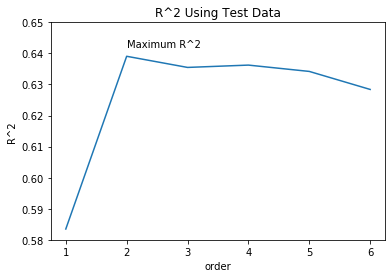

In [46]:
from sklearn.model_selection import train_test_split

dfc3 = dfc[['Income_Median','Housing_Median']]

xc = dfc3[['Income_Median']]
yc = dfc3['Housing_Median']
x_train, x_test, y_train, y_test = train_test_split(xc, yc, test_size=0.15, random_state=1)

lr = LinearRegression()

Rsqu_test = []
Rsqu_train = []

order = [1, 2, 3, 4, 5, 6]
for n in order:
    pr = PolynomialFeatures(degree=n)
    
    x_train_pr = pr.fit_transform(x_train[['Income_Median']])
    x_test_pr = pr.fit_transform(x_test[['Income_Median']])    
    
    lr.fit(x_train_pr, y_train)
    
    Rsqu_test.append(lr.score(x_test_pr, y_test))
    Rsqu_train.append(lr.score(x_train_pr, y_train))
ax1 = plt.plot(order, Rsqu_test)
plt.plot(order, Rsqu_train,'r')
plt.xlabel('order')
plt.ylabel('R^2')
plt.ylim(0.58, 0.65)
plt.title('R^2 Using Test Data')
plt.text(2, 0.642, 'Maximum R^2 ')  

plt.show()

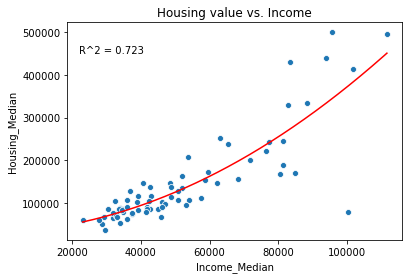

In [47]:
polynomial_features= PolynomialFeatures(degree=2)
x1 = polynomial_features.fit_transform(xc)

model1 = LinearRegression()
model1.fit(x1,yc)
R2 = model1.score(x1, yc)

xmax=max([xc.values.max()])
xmin=min([xc.values.min()])
x2=np.arange(xmin, xmax, 10)

y_hat = model1.predict(polynomial_features.fit_transform(x2.reshape(-1, 1)))

ax = sns.scatterplot(x='Income_Median',y='Housing_Median',data = dfc3)
ax.set(xlabel = 'Income_Median', ylabel = 'Housing_Median', title ='Housing value vs. Income')

plt.plot(x2,y_hat,'r')
plt.text(22000, 450000, 'R^2 = ' + str(0.723))  

plt.show()

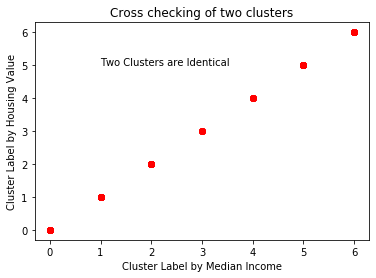

In [48]:
#plot showing label_c1 and label_c2 being identical
plt.plot(label_c1,label_c2,'ro')
plt.xlabel('Cluster Label by Median Income')
plt.ylabel('Cluster Label by Housing Value')

plt.title('Cross checking of two clusters')
plt.text(1, 5, 'Two Clusters are Identical')  

plt.show()

#### c.3) clustering by Age of Population 

In [49]:
dfc3 = dfc[['HoustonNeighborhoods','Latitude', 'Longitude', 'Age%_Under5','Age%_5_17','Age%_18_64','Age%_65up']]
dfc3_clustering = dfc[['Age%_Under5','Age%_5_17','Age%_18_64','Age%_65up']]

# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dfc3_clustering)

# check cluster labels generated for each row in the dataframe
label_c3 = kmeans.labels_[0:73] 
dfc3.insert(0, 'Cluster Labels', kmeans.labels_)
dfc3_clustering.insert(0, 'Cluster Labels', kmeans.labels_)

dfc3_clustering_grouped = dfc3_clustering.groupby('Cluster Labels').mean().reset_index()
dfc3_clustering_grouped

,Cluster Labels,Age%_Under5,Age%_5_17,Age%_18_64,Age%_65up
0,0,7.222222,14.777778,65.666667,12.333333
1,1,8.083333,19.833333,63.291667,8.666667
2,2,6.692308,18.153846,60.000000,15.384615
3,3,5.500000,5.500000,76.750000,12.000000
4,4,3.000000,4.333333,87.666667,4.666667
5,5,5.500000,13.125000,73.875000,7.500000
6,6,10.333333,22.916667,61.250000,5.666667


In [50]:
# create map of all clusters
map_clusters_c3 = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfc3['Latitude'], dfc3['Longitude'], dfc3['HoustonNeighborhoods'], dfc3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters_c3)
       
map_clusters_c3

In [51]:
# create map of cluster # 6 (day_care)
dfc3_c6 = dfc3.loc[dfc3['Cluster Labels'] == 6]

# create map of all clusters
map_clusters_c3_c6 = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfc3_c6['Latitude'], dfc3_c6['Longitude'], dfc3_c6['HoustonNeighborhoods'], dfc3_c6['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters_c3_c6)
       
map_clusters_c3_c6


In [52]:
dfc3_c6

,Cluster Labels,HoustonNeighborhoods,Latitude,Longitude,Age%_Under5,Age%_5_17,Age%_18_64,Age%_65up
17,6,79_Edgebrook,29.640117,-95.246973,9,23,60,8
26,6,2_Greater_Greenspoint,29.940700,-95.413900,14,23,59,4
27,6,78_Greater_HobbyArea,29.626363,-95.305170,10,21,63,6
32,6,69_GulfgateRiverview_PineValley,29.708500,-95.318100,10,22,61,8
33,6,27_Gulfton,29.716500,-95.480600,9,23,64,4
36,6,54_Hunterwood,29.817604,-95.225253,13,24,61,3
39,6,11_Langwood,29.827531,-95.497872,7,24,64,4
47,6,77_Minnetex,29.620402,-95.361335,10,25,58,7
51,6,58_Northshore,29.775800,-95.218300,11,21,61,7
52,6,45_Northside_Northline,29.859500,-95.384700,9,23,60,8


In [53]:
# create map of cluster # 2 (Senior Center)
dfc3_c2 = dfc3.loc[dfc3['Cluster Labels'] == 2]

# create map of all clusters
map_clusters_c3_c2 = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfc3_c2['Latitude'], dfc3_c2['Longitude'], dfc3_c2['HoustonNeighborhoods'], dfc3_c2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters_c3_c2)
       
map_clusters_c3_c2


In [54]:
dfc3_c2

,Cluster Labels,HoustonNeighborhoods,Latitude,Longitude,Age%_Under5,Age%_5_17,Age%_18_64,Age%_65up
1,2,23_AftonOaks_RiverOaks,29.749994,-95.433234,5,14,61,20
15,2,47_EastLittleYork_Homestead,29.881945,-95.329744,6,18,59,18
28,2,68_OST_SouthUnion,29.695266,-95.371262,7,18,61,14
35,2,7_Hidden_Valley,29.890077,-95.431909,5,21,60,14
38,2,52_Kashmere_Gardens,29.800757,-95.331510,7,17,61,15
45,2,31_Meyerland,29.686600,-95.464700,6,17,61,16
55,2,57_Pleasantville,29.770800,-95.272900,8,20,54,18
57,2,50_Settegast,29.841600,-95.293100,7,20,61,12
59,2,76_Southacres_CrestmontPark,29.623530,-95.392020,6,18,62,15
64,2,84_SpringBranch_North,29.819482,-95.561616,6,18,62,14


#### c.4) clustering by Ethnicity 

In [55]:
dfc4 = dfc[['HoustonNeighborhoods','Latitude', 'Longitude', 'Non_Hispanic%_W','Non_Hispanic%_B','Hispanic%','Non_Hispanic%_A','Nin_Hispanic%_O']]
dfc4_clustering = dfc[['Non_Hispanic%_W','Non_Hispanic%_B','Hispanic%','Non_Hispanic%_A','Nin_Hispanic%_O']]

# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dfc4_clustering)

# check cluster labels generated for each row in the dataframe
label_c4 = kmeans.labels_[0:73] 
dfc4.insert(0, 'Cluster Labels', kmeans.labels_)
dfc4_clustering.insert(0, 'Cluster Labels', kmeans.labels_)

dfc4_clustering_grouped = dfc4_clustering.groupby('Cluster Labels').mean().reset_index()
dfc4_clustering_grouped


,Cluster Labels,Non_Hispanic%_W,Non_Hispanic%_B,Hispanic%,Non_Hispanic%_A,Nin_Hispanic%_O
0,0,19.272727,14.636364,56.454545,8.545455,0.727273
1,1,62.300000,9.200000,13.800000,12.200000,2.500000
2,2,5.400000,73.000000,18.300000,2.200000,1.000000
3,3,36.888889,23.666667,25.555556,12.111111,1.888889
4,4,5.000000,50.571429,41.428571,2.000000,1.142857
5,5,8.235294,6.941176,82.529412,1.470588,0.588235
6,6,6.666667,27.444444,63.444444,2.000000,0.333333


In [56]:
# create map of all clusters
map_clusters_c4 = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfc4['Latitude'], dfc4['Longitude'], dfc4['HoustonNeighborhoods'], dfc4['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters_c4)
       
map_clusters_c4

In [57]:
# create map of cluster = 5 (Hispanic)

dfc4_c5 = dfc4.loc[dfc4['Cluster Labels'] == 5]
map_clusters_c4_c5 = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfc4_c5['Latitude'], dfc4_c5['Longitude'], dfc4_c5['HoustonNeighborhoods'], dfc4_c5['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters_c4_c5)
       
map_clusters_c4_c5


In [58]:
dfc4_c5

,Cluster Labels,HoustonNeighborhoods,Latitude,Longitude,Non_Hispanic%_W,Non_Hispanic%_B,Hispanic%,Non_Hispanic%_A,Nin_Hispanic%_O
12,5,56_DenverHarbor_PortHouston,29.774400,-95.301100,3,7,89,0,0
17,5,79_Edgebrook,29.640117,-95.246973,11,7,80,1,1
24,5,64_Greater_Eastwood,29.735700,-95.334000,15,5,78,2,0
32,5,69_GulfgateRiverview_PineValley,29.708500,-95.318100,5,6,88,1,0
33,5,27_Gulfton,29.716500,-95.480600,7,12,73,6,2
34,5,65_Harrisburg_Manchester,29.718500,-95.260200,3,14,82,0,0
39,5,11_Langwood,29.827531,-95.497872,13,9,76,0,2
40,5,88_Lawndale_Wayside,29.722815,-95.324774,9,3,87,1,1
42,5,82_Magnolia_Park,29.737200,-95.292500,3,1,95,0,0
43,5,75_Meadowbrook_Allendale,29.685181,-95.283277,10,3,85,2,0


In [59]:
# create map of cluster = 1 (Non_Hispanic Asian)

dfc4_c1 = dfc4.loc[dfc4['Cluster Labels'] == 1]
map_clusters_c4_c1 = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfc4_c1['Latitude'], dfc4_c1['Longitude'], dfc4_c1['HoustonNeighborhoods'], dfc4_c1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters_c4_c1)
       
map_clusters_c4_c1


In [60]:
dfc4_c1

,Cluster Labels,HoustonNeighborhoods,Latitude,Longitude,Non_Hispanic%_W,Non_Hispanic%_B,Hispanic%,Non_Hispanic%_A,Nin_Hispanic%_O
1,1,23_AftonOaks_RiverOaks,29.749994,-95.433234,77,4,10,7,2
5,1,32_Braeswood_Place,29.695000,-95.430000,61,10,12,15,2
10,1,81_Clear_Lake,29.585700,-95.132800,54,8,20,14,4
30,1,21_Greater_Uptown,29.748729,-95.480928,67,5,16,10,2
31,1,87_Greenway_UpperKirby,29.731922,-95.444807,69,6,14,9,2
44,1,33_Medical_Center,29.708573,-95.405690,52,16,12,16,4
45,1,31_Meyerland,29.686600,-95.464700,58,11,16,13,2
46,1,62_Midtown,29.740800,-95.375600,63,16,13,6,1
48,1,66_MuseumPark,29.724721,-95.391874,54,10,16,17,3
67,1,28_University_Place,29.714344,-95.419076,68,6,9,15,3


### Section 4: Examples of Application from the Data Analysis

#### a). Potential location of new day-care center for Hispanic community

In [61]:
index1 = dfc3_c6.index.to_numpy()
index2 = dfc4_c5.index.to_numpy()
index1b = []
for i in index1:
    for j in index2:
        if i == j:
            index1b.append(i)

In [62]:
dfc3c6 = dfc3_c6.loc[index1b, :]
dfc3c6.drop(['Cluster Labels'],axis =1, inplace = True)
dfc3c6

,HoustonNeighborhoods,Latitude,Longitude,Age%_Under5,Age%_5_17,Age%_18_64,Age%_65up
17,79_Edgebrook,29.640117,-95.246973,9,23,60,8
32,69_GulfgateRiverview_PineValley,29.708500,-95.318100,10,22,61,8
33,27_Gulfton,29.716500,-95.480600,9,23,64,4
39,11_Langwood,29.827531,-95.497872,7,24,64,4
51,58_Northshore,29.775800,-95.218300,11,21,61,7
52,45_Northside_Northline,29.859500,-95.384700,9,23,60,8
53,74_Park_Place,29.694865,-95.289804,9,22,63,6


In [63]:
dfc4c5 = dfc4_c5.loc[index1b, :]
dfc4c5.drop(['Cluster Labels'],axis =1, inplace = True)
dfc4c5

,HoustonNeighborhoods,Latitude,Longitude,Non_Hispanic%_W,Non_Hispanic%_B,Hispanic%,Non_Hispanic%_A,Nin_Hispanic%_O
17,79_Edgebrook,29.640117,-95.246973,11,7,80,1,1
32,69_GulfgateRiverview_PineValley,29.708500,-95.318100,5,6,88,1,0
33,27_Gulfton,29.716500,-95.480600,7,12,73,6,2
39,11_Langwood,29.827531,-95.497872,13,9,76,0,2
51,58_Northshore,29.775800,-95.218300,12,11,76,1,0
52,45_Northside_Northline,29.859500,-95.384700,7,9,84,0,0
53,74_Park_Place,29.694865,-95.289804,4,4,87,4,1


In [64]:
# day care center (large youth%) in Hispanic community (large % of Hispanic)
dfc3c6c4c5 = pd.merge(dfc3c6, dfc4c5, how='inner')
dfc3c6c4c5.drop(['Age%_18_64','Age%_65up','Non_Hispanic%_W','Non_Hispanic%_B','Non_Hispanic%_A','Nin_Hispanic%_O'],axis =1, inplace = True)
dfc3c6c4c5

,HoustonNeighborhoods,Latitude,Longitude,Age%_Under5,Age%_5_17,Hispanic%
0,79_Edgebrook,29.640117,-95.246973,9,23,80
1,69_GulfgateRiverview_PineValley,29.708500,-95.318100,10,22,88
2,27_Gulfton,29.716500,-95.480600,9,23,73
3,11_Langwood,29.827531,-95.497872,7,24,76
4,58_Northshore,29.775800,-95.218300,11,21,76
5,45_Northside_Northline,29.859500,-95.384700,9,23,84
6,74_Park_Place,29.694865,-95.289804,9,22,87


In [65]:
# create map of day care center (large youth%) in Hispanic community (large % of Hispanic)
import folium
map_c3c6c4c5 = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(dfc3c6c4c5['Latitude'], dfc3c6c4c5['Longitude'], dfc3c6c4c5['HoustonNeighborhoods']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_c3c6c4c5)  
    
map_c3c6c4c5

#### b). Potential location of new senior-care center for Asian community

In [66]:
index1 = dfc3_c2.index.to_numpy()
index2 = dfc4_c1.index.to_numpy()
index1b = []
for i in index1:
    for j in index2:
        if i == j:
            index1b.append(i)

In [67]:
dfc3c2 = dfc3_c2.loc[index1b, :]
dfc3c2.drop(['Cluster Labels'],axis =1, inplace = True)
dfc3c2

,HoustonNeighborhoods,Latitude,Longitude,Age%_Under5,Age%_5_17,Age%_18_64,Age%_65up
1,23_AftonOaks_RiverOaks,29.749994,-95.433234,5,14,61,20
45,31_Meyerland,29.686600,-95.464700,6,17,61,16


In [68]:
dfc4c1 = dfc4_c1.loc[index1b, :]
dfc4c1.drop(['Cluster Labels'],axis =1, inplace = True)
dfc4c1


,HoustonNeighborhoods,Latitude,Longitude,Non_Hispanic%_W,Non_Hispanic%_B,Hispanic%,Non_Hispanic%_A,Nin_Hispanic%_O
1,23_AftonOaks_RiverOaks,29.749994,-95.433234,77,4,10,7,2
45,31_Meyerland,29.686600,-95.464700,58,11,16,13,2


In [69]:
# senior care center (large age% 65up) in Asian community (large % of non_Hispanic_A)
dfc3c2c4c1 = pd.merge(dfc3c2, dfc4c1, how='inner')
dfc3c2c4c1.drop(['Age%_Under5','Age%_5_17','Non_Hispanic%_W','Non_Hispanic%_B','Hispanic%','Nin_Hispanic%_O'],axis =1, inplace = True)
dfc3c2c4c1

,HoustonNeighborhoods,Latitude,Longitude,Age%_18_64,Age%_65up,Non_Hispanic%_A
0,23_AftonOaks_RiverOaks,29.749994,-95.433234,61,20,7
1,31_Meyerland,29.686600,-95.464700,61,16,13


In [70]:
# create map of day care center (large youth%) in Hispanic community (large % of Hispanic)
import folium
map_c3c2c4c1 = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(dfc3c2c4c1['Latitude'], dfc3c2c4c1['Longitude'], dfc3c2c4c1['HoustonNeighborhoods']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_c3c2c4c1)  
    
map_c3c2c4c1


#### This concludes the code, thank you.